Facial expression detection

In [62]:
import torch
torch.cuda.is_available()

False

In [63]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4608, 2048)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(2048, 128)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(128, 32)
        self.relu5 = nn.ReLU()
        self.fc_out = nn.Linear(32, 7)

    def forward(self, x):
        # Input Convolutional Layer
        x = self.conv1(x)
        x = self.relu1(x)

        # First MaxPooling Layer
        x = self.pool1(x)

        # Second Convolutional Layer
        x = self.conv2(x)
        x = self.relu2(x)

        # Second MaxPooling Layer
        x = self.pool2(x)

        # Flatten Layer
        x = self.flatten(x) # Flatten

        # First Dense (Fully Connected) Layer
        x = self.fc1(x)
        x = self.relu3(x)

        # Second Dense (Fully Connected) Layer
        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        x = self.relu5(x)

        # Final Dense Layer (Regression Output)
        x = self.fc_out(x)

        return x

In [64]:
import os
from PIL import Image
import numpy as np

# Importing dataset
path = "images/images/"
path2 = "./"

# Model path
model_path = "model.pth"

for dir in os.listdir(path):
    print(dir)

train
validation


In [65]:
def convert_label(label):
    if label == 'angry':
        return 1
    elif label == 'disgust':
        return 0
    elif label == 'fear':
        return 4
    elif label == 'happy':
        return 5
    elif label == 'neutral':
        return 3
    elif label == 'sad':
        return 2
    elif label == 'surprise':
        return 6
    else:
        raise ValueError("Strange label")

def open_set(path, set_path):
    image_data = []
    image_labels = []

    for dir in os.listdir(os.path.join(path, set_path)):
        for img in os.listdir(os.path.join(path, set_path, dir)):
            
            filepath = os.path.join(path, set_path, dir, img) # Filename
            image = Image.open(filepath) # Image
            numpy_array = np.array(image)
            image_data.append(numpy_array)
            image_labels.append(convert_label(dir))

    return np.array(image_data), np.array(image_labels)

In [66]:
image_train_data, image_train_labels = open_set(path, "train")
image_test_data, image_test_labels = open_set(path, "validation")

print(image_train_data.shape)
print("Shape of Image Data: ", image_train_data[0].shape)
print("Number of images: ", len(image_train_data))

(28821, 48, 48)
Shape of Image Data:  (48, 48)
Number of images:  28821


Label: 0


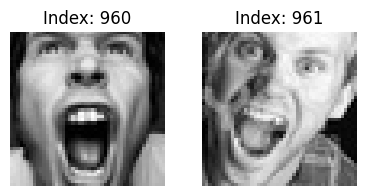

Label: 1


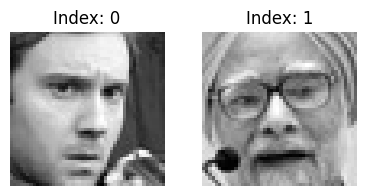

Label: 2


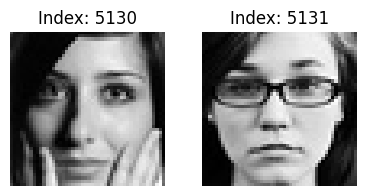

Label: 3


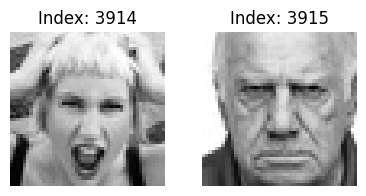

Label: 4


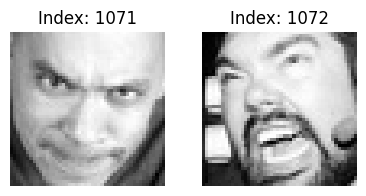

Label: 5


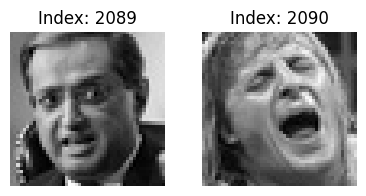

Label: 6


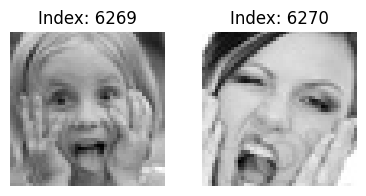

In [67]:
def imshow_first_n_per_label(images, labels, n=2):
    """Displays the first n images for each unique label using matplotlib's imshow."""
    unique_labels = np.unique(labels)
    for label in unique_labels:
        print(f"Label: {label}")
        indices = np.where(labels == label)[0]
        first_n_indices = indices[:n]
        num_to_show = len(first_n_indices)
        if num_to_show > 0:
            fig, axes = plt.subplots(1, num_to_show, figsize=(2 * num_to_show, 2))
            if num_to_show == 1:
                axes = [axes]  # Make sure axes is iterable even for a single image
            for i, index in enumerate(first_n_indices):
                image = images[index]
                axes[i].imshow(image, cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(f"Index: {index}")
            plt.tight_layout()
            plt.show()
        else:
            print("  No images found for this label.")

imshow_first_n_per_label(image_train_data, image_test_labels)

In [98]:
# Load and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# Move data to device
image_train_normalized = image_train_data.astype('float32') / 255.0
train_tensor = torch.tensor(image_train_normalized, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(image_train_labels, dtype=torch.long).to(device)
train_dataset = TensorDataset(train_tensor, y_train_tensor)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)

# Move data to device
image_test_normalized = image_test_data.astype('float32') / 255.0
test_tensor = torch.tensor(image_test_normalized, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(image_test_labels, dtype=torch.long).to(device)
test_dataset = TensorDataset(test_tensor, y_test_tensor)

# Create DataLoaders
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=200, shuffle=False)

cpu


In [75]:
def train_model(model, data_loader, x_tensor, y_tensor, criterion, optimizer, num_epochs, target_accuracy, save_path):
    accuracies = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")): # Add epoch/total
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)

            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

        avg_loss = total_loss / len(data_loader.dataset)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch: {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
        accuracies.append(train_accuracy)

        torch.save(model.state_dict(), save_path)

        if train_accuracy > target_accuracy:
            print(f"Reached target accuracy of {target_accuracy:.2f} at epoch {epoch+1}. Training finished.")
            break

    print("Training complete.")
    return accuracies

In [70]:
for batch in train_loader:
    images, labels = batch
    print("Shape of image batch:", images.shape)
    break # Only inspect the first batch

Shape of image batch: torch.Size([200, 1, 48, 48])


In [100]:
try:
    emotion_classifier = NeuralNetwork().to(device)
    emotion_classifier.load_state_dict(torch.load(model_path, weights_only=True))
    print("Scuccessfully loaded model")
except:
    emotion_classifier = NeuralNetwork().to(device)
    print("Created new model")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=emotion_classifier.parameters(), lr=0.05)
target_accuracy = 0.95
num_epochs = 50


Created new model


In [101]:
accuracies = []

In [ ]:
next_accuracies = train_model(emotion_classifier, train_loader, train_tensor, y_train_tensor, criterion, optimizer, num_epochs, target_accuracy, model_path)
accuracies += next_accuracies

Epoch 1/50: 100%|██████████| 145/145 [00:49<00:00,  2.91it/s]


Epoch: 1/50, Average Loss: 1.8560, Training Accuracy: 0.2367


Epoch 2/50: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]


Epoch: 2/50, Average Loss: 1.8100, Training Accuracy: 0.2484


Epoch 3/50: 100%|██████████| 145/145 [00:49<00:00,  2.95it/s]


Epoch: 3/50, Average Loss: 1.8022, Training Accuracy: 0.2475


Epoch 4/50: 100%|██████████| 145/145 [00:53<00:00,  2.73it/s]


Epoch: 4/50, Average Loss: 1.7911, Training Accuracy: 0.2514


Epoch 5/50: 100%|██████████| 145/145 [00:53<00:00,  2.73it/s]


Epoch: 5/50, Average Loss: 1.7793, Training Accuracy: 0.2613


Epoch 6/50: 100%|██████████| 145/145 [00:53<00:00,  2.69it/s]


Epoch: 6/50, Average Loss: 1.7669, Training Accuracy: 0.2714


Epoch 7/50: 100%|██████████| 145/145 [00:52<00:00,  2.77it/s]


Epoch: 7/50, Average Loss: 1.7431, Training Accuracy: 0.2951


Epoch 8/50: 100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epoch: 8/50, Average Loss: 1.7155, Training Accuracy: 0.3156


Epoch 9/50: 100%|██████████| 145/145 [00:54<00:00,  2.66it/s]


Epoch: 9/50, Average Loss: 1.6827, Training Accuracy: 0.3373


Epoch 10/50: 100%|██████████| 145/145 [00:54<00:00,  2.66it/s]


Epoch: 10/50, Average Loss: 1.6533, Training Accuracy: 0.3522


Epoch 11/50: 100%|██████████| 145/145 [00:53<00:00,  2.72it/s]


Epoch: 11/50, Average Loss: 1.6258, Training Accuracy: 0.3690


Epoch 12/50:   6%|▌         | 9/145 [00:03<00:51,  2.65it/s]

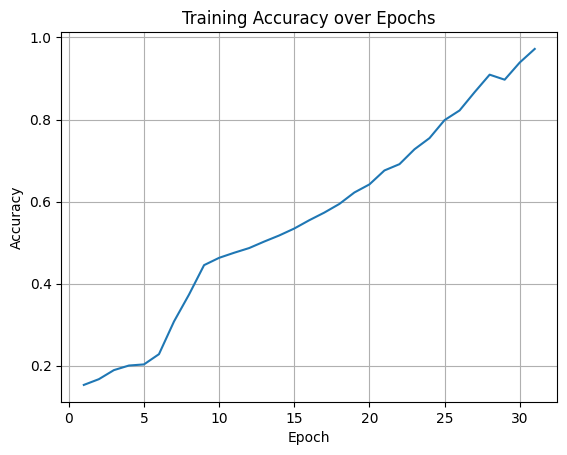

In [92]:
def plot_array_line(data):
  """
  Generates a line plot of an array's values against their index + 1.

  Args:
      data: A list or numpy array of numerical values.
  """

  x_values = np.arange(len(data)) + 1 # Create x-axis values starting from 1
  plt.plot(x_values, data) # Plot the data
  plt.xlabel("Epoch") # Set x-axis label
  plt.ylabel("Accuracy") # Set y-axis label
  plt.title("Training Accuracy over Epochs") # Set plot title
  plt.grid(True) # Add a grid for better readability
  plt.show() # Display the plot

plot_array_line(accuracies)

In [99]:
def evaluate_model(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_samples = 0
        for (data, target) in data_loader: # Add epoch/total
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

    eval_accuracy = correct_predictions / total_samples
    return eval_accuracy

evaluate_model(emotion_classifier, test_loader)

0.5186810076422304